<img src="https://i.ibb.co/DtHQ3FG/802x265-Logo-GT.png\" width="700"> 


# Transformada Wavelets

&emsp; Transformadas wavelets consistem de transformações matemáticas de extrema importância para análises de sinais. Entretanto sua compreensão é consideravelmente complexa, assim, visando reduzir as barreiras de sua completa funcionalidade, vou tentar explicar aqui todo o contexto de formação deste processo matemático desenvolvido no início do século XX. Antes de abordar propriamente as transformadas wavelets é necessário voltarmos para o contexto das transformadas de Fourier, visto que esta foi motivação essencial para o desenvolvimento das wavelets.

## Transformada de Fourier

&emsp;A transformada de Fourier é um importante recurso de análise de sinais que consiste na decomposição de um sinal temporal em seus vários componentes espectrais de frequência, facilitando, e muito, por exemplo a análise de sinais ruidosos, ou muito confusos. Para tal a transformada de Fourier tenta decompor um sinal em uma somatória de senoides, estas senoides podem ser de qualquer frequência, isto o algoritmo irá buscar, cada senoide sendo representativa de apenas uma frequência. Estas senoides são chamadas de harmônicas. Observe a fórmula abaixo:

$$F(\omega) = \int_{-\infty}^{\infty} \;f(t)\, e^{-j\omega t}\,dt$$

Esta fórmula representa a transformada de Fourier de tempo contínuo, ela também pode ser definida para tempo discreto, note como a integral é definida de menos infinito a mais infinito. Veja a figura abaixo:

<img src="imgs/fourier.png" width="600">

É possível perceber, pelo sinal no domínio temporal, que não é muito simples fazer uma análise de quais frequências compõe o mesmo, mas ao realizar a transformada de Fourier, que decompõe o sinal temporal em uma somatória de senoides, de diferentes frequências, fica mais simples realizar a análise no domínio da frequência, mostrada pela figura a direita, que mostra de forma bastante simples quais frequências tem maior relevância na composição daquele sinal, tornando mais simples, por exemplo, o processo de análise e filtragem de frequências espúrias. Um exemplo real desta aplicação é na área médica com o famoso ECG ou eletrocardiograma, que avalia a atividade elétrica de sístole e diástole do coração por meio dos impulsos nervosos gerados pelos nódulos, notoriamente o sino-auricular. Entretanto este tipo de exame está sujeito à diversos problemas, entre eles o fato que a medição é feita pela pele, estando consideravelmente distante do coração, tentando medir um sinal da ordem de mV. Nestas condições é natural que ocorram artefatos de medição, o problema é que estes artefatos podem atrapalhar consideravelmente a visualização do exame. O principal deles é a frequência de 60 Hz, geralmente introduzida pela corrente de energização do aparelho ECG, visto que este é alimentado pela corrente externa, que oscila com 60 Hz. Neste caso é simples, sabemos a origem do ruído e podemos projetar um filtro, mas em casos que o ruído é desconhecido e igualmente significativo em termos de atrapalhar a medição, é necessário realizar a transformada de Fourier do sinal, encontrar a frequência ruidosa e projetar um filtro para sua remoção. Este consiste apenas de um dos vários exemplos da transformada de Fourier.

&emsp; Vejamos como podemos fazer este passo-a-passo descrito acima mas de forma prática, utilizando o python. Este código foi adaptado do material dos professores [Steven. L. Brunton & J. Nathan Kutz](http://databookuw.com/), que é uma excelente referência para o tema. Primeiramente vamos considerar o seguinte código:

In [16]:
# Apenas para remover warnings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML

'''display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 99%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))'''

'display(HTML(data="""\n<style>\n    div#notebook-container    { width: 95%; }\n    div#menubar-container     { width: 99%; }\n    div#maintoolbar-container { width: 99%; }\n</style>\n"""))'

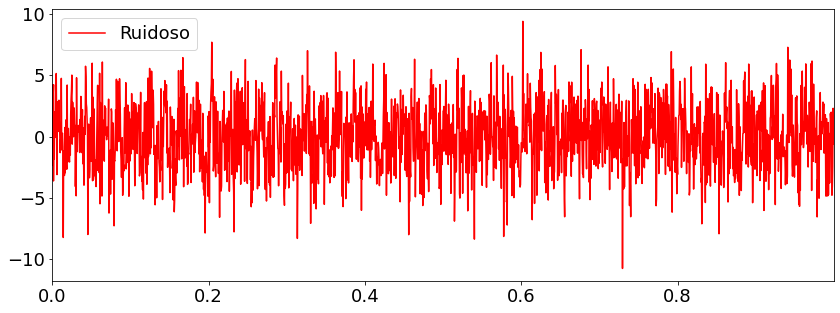

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 5]
plt.rcParams.update({'font.size': 18})

# Cria um sinal sintético com duas frequências: 120Hz e 50Hz
dt = 0.0005                                      # Espaçamento temporal utilizado
t = np.arange(0,1,dt)                            # Vetor tempo
f = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t) # Soma das senoides com as frequências citadas
f_limpo = f                                      # Armazenamos o sinal limpo
f = f + 2.5*np.random.randn(len(t))              # Adiona ruído ao sinal anterior

# Ploting
plt.plot(t, f, color='r', LineWidth=1.5, label='Ruidoso')
#plt.plot(t, f_limpo, color='k', LineWidth=1.5, label='Limpo')
plt.xlim(t[0],t[-1])
plt.legend()
plt.show()

Acima nós simplesmente fabricamos um dataset, com um sinal limpo em preto, proveniente da soma de duas senoides, e juntamente a estas senoides somamos um sinal ruidoso, de grande amplitude. Vamos fazer um exercício de faz de conta, fingindo que o sinal preto não existe, não sabemos que ele está presente no sinal vermelho, e apenas temos acesso ao sinal ruidoso, mas sabendo que o sinal vermelho possuí diversos artefatos que estão complicando nossa análise. Assim vamos buscar encotrar as frequências significativas e filtrar as outras. Para tal vamos utilizar o fast fourier transform, que é uma implementação da transformada de fourier, mas com algumas modificações que não vem ao caso neste texto. Temos:

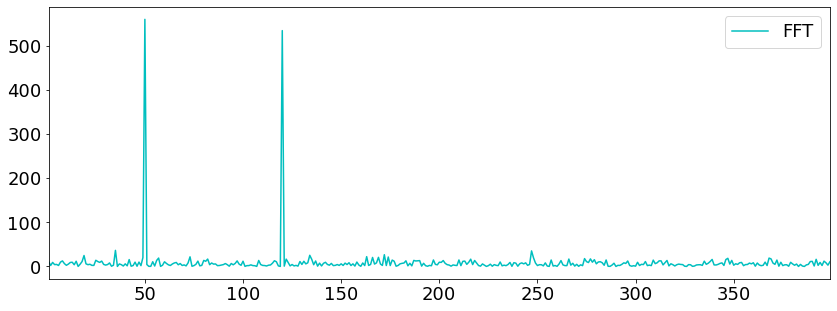

In [3]:
## Computando a Fast Fourier Transform (FFT)

n = len(t)
fhat = np.fft.fft(f,n)                     # Computa a FFT
DEP = fhat * np.conj(fhat) / n             # Espectro de potência (potÇencia por freq)
freq = (1/(dt*n)) * np.arange(n)           # Cria um eixo de frequências, a partir do eixo temporal
L = np.arange(1,np.floor(n/5),dtype='int') # Plota apenas as primeiras frequências

# Ploting
plt.plot(freq[L], DEP[L], color='c', LineWidth=1.5, label='FFT')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()
plt.show()

No domínio da frequência fica bastante evidente a influência de potência dominante por duas frequências no sinal, todo o resto podendo ser considerado como ruído. Portanto vamos agora filtrar estes sinais, de forma bastante simples, basta escolher um valores de threshold para a potência, se o valor for inferior ao limite, aquele espectro é zerado, caso contrário não. Pela análise do gráfico basta escolher algo como 200:

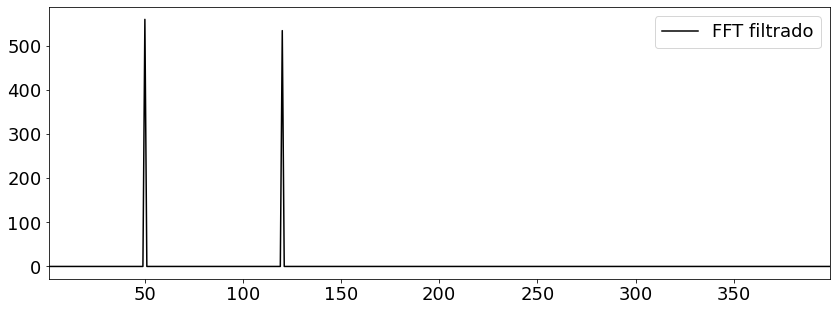

In [4]:
## Usando a potência para filtrar o ruído
indices = DEP > 200       # Encontra as potências maiores que o threshold
DEPlimpo = DEP * indices  # Zera todos os outros indices

# Ploting
plt.plot(freq[L], DEPlimpo[L], color='k', LineWidth=1.5, label='FFT filtrado')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()
plt.show()

Por fim podemos agora realizar a transformada inversa rápida de Fourier para conseguirmos o sinal original:

In [5]:
fhat_filtrado = indices * fhat     # Zera todos os coeficientes da transformada de fourier
ffilt = np.fft.ifft(fhat_filtrado) # FFT inversa para o sinal filtrado

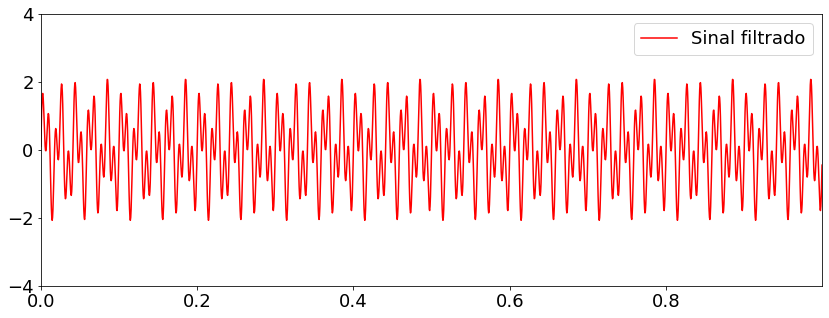

In [6]:
# Ploting
plt.plot(t, ffilt, color='r', LineWidth=1.5, label='Sinal filtrado')
plt.xlim(t[0], t[-1])
plt.ylim(-4, 4)
plt.legend()
plt.show()

&emsp; Desta forma podemos compreender de forma prática a importância desta ferramenta para análise de séries temporais, mas como ela se aplica à imagens? Bem é possível definir a transformada de Fourier em 2 dimensões e aplicar a mesma para imagens, no proprio numpy a impĺementação é dada por ```np.fft.fft2```. Vale dizer que não estaríamos realizando nada muito novo, apenas aplicando a transformação em todas colunas, depois em todas linhas, ou vice e versa (não importa em nada qual direção você escolher transformar primeiro). Vejamos o código a seguir:


(-0.5, 489.5, 329.5, -0.5)

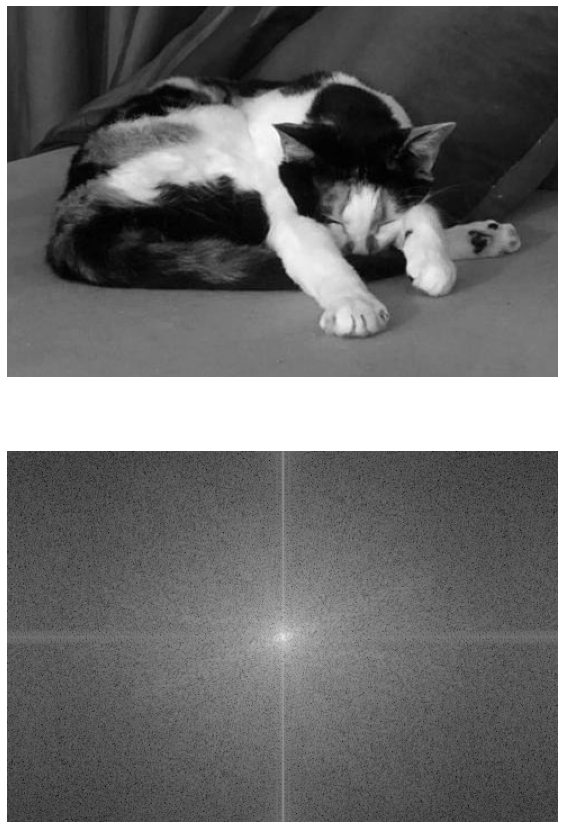

In [7]:
from matplotlib.image import imread
import os
plt.rcParams['figure.figsize'] = [16, 15]
plt.rcParams.update({'font.size': 18})

path = 'imgs/luna.jpeg'

A = imread(path)
B = np.mean(A, -1); # Convert RGB to grayscale

fig,axs = plt.subplots(2,1)

# Plot image
img = axs[0].imshow(B)
img.set_cmap('gray')
axs[0].axis('off')

# Computando a fft2 do gatinho
D = np.fft.fft2(B)

# Plot image
img = axs[1].imshow(np.fft.fftshift(np.log(np.abs(D))))
img.set_cmap('gray')
axs[1].axis('off')

A imagem da direita acima nada mais é que uma representação dos diversos coeficientes da transformada rápida de Fourier, ou seja, em cada ponto daquela imagem temos a informação da magnitude se uma multiplicação de senos e cossenos, bem como suas fases, e o que estamos tentando fazer nada mais é que para cada pixel na imagem original encontrar uma soma de senos e cossenos de diferentes frequências que resultem no mesmo padrão observado pela imagem original, criado por suas intensidades. Agora eu sei que isso não faz o menor sentido simplesmente falando assim para vocês, até pq como a imagem da direita poderia ser uma representação da imagem na esquerda se elas não tem absolutamente nenhuma ligação visual, mas eu devo lembrar que a imagem à direita trata apenas de coeficientes, não de valores de pixels em sí, e para ficar mais claro eu quero mostrar a seguinte representação da imagem à esquerda:

<IPython.core.display.Javascript object>


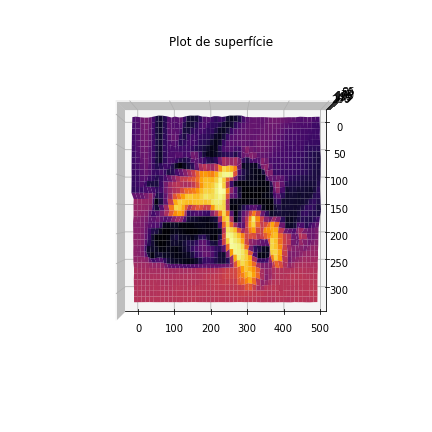

In [8]:
%matplotlib notebook

from mpl_toolkits.mplot3d import axes3d
plt.rcParams['figure.figsize'] = [6, 6]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(np.arange(1, np.shape(B)[1]+1), np.arange(1, np.shape(B)[0]+1))
ax.plot_surface(X[0::10, 0::10], Y[0::10, 0::10], B[0::10, 0::10], cmap='inferno', edgecolor='none')
ax.set_title('Plot de superfície')
ax.mouse_init()
ax.view_init(270,270)
plt.show()

Perceba como é possível representar uma imagem como se ela fosse na verdade uma sequência de valores de uma time series, então os vários coeficientes da transformada rápida de Fourier 2d está tentando somar senos e cossenos em cada ponto da imagem para recriar o padrão descrito pelo plot de superfície acima. 

&emsp; Mas este processo por sí só não é extremamente relevante, é importante entender que a partir disto podemos realizar diversas transformaçõoes na nossa imagem, sendo as mais comuns a compressão e a filtragem de ruído, mas ambas eu vou descrever somente quando passarmos por wavelets, uma vez que já me estendi demais nesta parte do notebook :). Entretanto, após falar tanto, a transformada de Fourier não é perfeita, ela apresenta um grande problema que é apenas apresentar informações sobre as frequências do sinal, mas não quando esta frequência aparece no tempo. Uma forma de pensar essas transformações é em termos de resolução espectral, mas isso é tão importante que vou dedicar uma subseção apenas para isso.

### Resolução espectral:

&emsp; A resolução de uma transformada mostra o quão bem dividido está o sinal em termos de algum eixo que buscamos representar. No eixo do tempo, em que nossa função estava originalmente, temos uma grande resolução temporal, mas a resolução de frequências é muito baixa, a informação de frequências naquela representação não é relevante. Ao fazer a transformação de Fourier passamos a ter uma alta resolução de frequência do sinal, mas a resolução temporal fica excessivamente baixa. Veja a imagem a seguir:

<img src="imgs/fourier_res.png" width="600">

Na base normal temos o eixo do tempo muito bem dividido, é possível verificar que há uma grande resolução temporal, visto que este eixo pode ser dividido em vários pequenos pedaços. Por outro lado a resolução de frequência é baixa, não há nenhuma subdivisão indicando que esta representação não está apta a analisar o espaço em termos de frequências (todas frequências são a mesma para esta representação). Já na representação de Fourier o sinal está melhor dividido na frequência, com uma alta resolução nesta, mas a informação temporal se perde, visto que sua resolução no tempo é muito baixa, nula neste caso. Explicada esta questão da resolução vamos partir para uma modificação no método de Fourier para considerar o tempo na análise.

## Transformada de Fourier de tempo curto (STFT)

&emsp; Eu verdadeiramente já me alonguei demais nas partes menos interessantes, afinal o texto era para ser sobre wavelets, mas a transformada de Fourier é um importante fundamento da transformada wavelet por isso vale a pena gastar tanta energia nele, o mesmo não pode ser dito sobre os métodos espectrais, como a STFT, visto que as wavelets são um tipo de transformada espectral, por isso eu vou ser muito breve nesta parte, apenas para ressaltar as diferenças importantes. 

&emsp; Bem a STFT nada mais é que um método de reintroduzir o tempo na análise, tentando romper com a barreira citada no final da seção anterior. Mas isso não é nada fácil, considerando que o a única forma de fazer isso implica em um trade-off entre resolução temporal e de frequências. Para ficar mais claro a STFT funciona com janelamento, considerando que o sinal analisado é composto, em cada instante, por algumas frequências dominantes, então em cada instante de tempo de janelamento, aplica-se a transformada de Fourier no sinal da janela, o que estiver fora da janela é automaticamente zerado, assim temos:

<img src="https://www.mathworks.com/help/examples/signal/win64/STFTOfMultichannelSignalsExample_02.png" align="center" border="0" width="550" />

A imagem acima representa bem o resultado de uma STFT, trata-se de um plot 3D com um eixo representando a mudança de frequências, outro eixo representando as mudanças temporais e o terceiro tem a magnitude ou potência dos sinais. O problema deste método é justamente seu trade-off de resoluções, neste caso quanto maior for o janelamento melhor a resolução de frequências, visto que mais mais frequências estão na janela, porém menor é a resolução temporal, ao passo que a quanto menor o janelamento melhor seria a resolução temporal, porém pior é a resolução espectral. Neste algorítmo é normal usar o janelamento igualmente dividido, como na figura abaixo:

<img src="imgs/fourier_win_res.png" width="250">

Trata-se de uma solução ao problema apresentado anteriormente, mas não é nem de longe a melhor, as wavelets são uma solução bem mais eficiente. Assim temos o que é necessário para compreender bem as transformadas wavelet.

## Wavelets e suas transformadas:

&emsp; As transformadas wavelets são uma opção mais otimizadas em relação às STFT para resolver o problema, sem muitas delongas quero apresentar logo o grid:

<img src="imgs/wav_res.png" width="250">

Numa primeira olhada ele parece devidamente estranho, né? Mas existem ótimas justificativas para esta divisão. Vejamos, primeiramente, que em baixas frequências a resolução temporal é baixa, correto? Sim, ela é baixa pois em baixas frequências a mudança ocorre de forma lenta no tempo, ou seja, não precisamos ter uma grande resolução para medir coisas que mudam de forma lenta, mas conforme a frequência aumenta é necessário aumentar a resolução temporal, visto que agora as coisas mudam mais rapidamente no tempo, mas podemos abrir mão da resolução espectral, já que ela geralmente as frequências altas são menos significativas no sistema. E assim temos a estrutura em grid mostrada. Vale dizer que esta estrutura pode ser definida por você para satisfazer as suas necessidades.


&emsp; Para conseguir este padrão a transformada wavelet vai funcionar de forma similar à transformada de Fourier, ela toma a função de análise e projeta a mesma sobre uma base ortogonal, a grande diferença neste caso é que a base ortogonal utilizada neste caso não será meramente uma junção de senos e cossenos, mas uma hierarquia de funções ortogonais, que vão ficando cada vez menores no tempo (ou no espaço, no caso de imagens) para justamente se encaixarem nestes menores retângulos de resolução na imagem acima. Essas funções descritas são chamadas de wavelets, elas devem ser funções ortogonais, ou seja, integral nula no tempo, e podem ter diferentes formatos, por isso que existem diversas transformadas wavelets, porque a função wavelet utilizada pode variar, alguns tipos são:

<img src="https://www.researchgate.net/profile/M_Afendi_M_Piah/publication/299550014/figure/fig2/AS:667720970428438@1536208493901/Examples-of-types-of-wavelets-7.ppm" align="center" border="0" width="550" />

Todas estas funções serão então descritas como sendo uma $\Psi(t)$. Esta função será a "wavelet mãe" que dará origem à outars variações de wavelets usadas para serem adaptadas à cada uma das resoluções. A função genérica da wavelet em função da wavelet mãe é:

# $$\Psi_{a,b}(t) = \frac{1}{\sqrt{a}}\, \Psi\left(\frac{t-b}{a}\right)$$

É possível notar que os fatores $a$ e $b$ definem deslocamento e o escalonamento da função, então o valor de $b$ desloca a função no tempo, escolhendo para qual retângulo da esquerda para a direita aquela variação de wavelet corresponde, enquanto que o parâmetro $a$ aumenta ou encolhe a função no tempo, e isso essencialmente corresponde à aumentar ou diminuir a frequência da onda, escolhendo verticamente qual seria o retângulo correspondente. Para entender melhor veja a imagem abaixo:

<img src="https://www.researchgate.net/profile/Ja_Antonino-Daviu/publication/229021791/figure/fig1/AS:300840775634946@1448737438459/Each-plot-represents-the-mother-wavelet-in-blue-and-one-of-his-sons-in-red-The.png" align="center" border="0" width="550" />

A curva em azul em todos os casos mostra a wavelet mãe, enquanto que para cada quadro temos uma vairação possível em termos dos parâmetros $a$ e $b$. Veja agora como cada wavelet "filha" preenche o retângulo de resolução:

<img src="https://www.researchgate.net/profile/Arnab_Gupta5/publication/320044525/figure/fig4/AS:614347147591693@1523483182357/Basis-functions-and-time-frequency-resolution-of-the-Wavelet-Transform-from-Vetterli.png" align="center" border="0" width="550" />

Em se tratando de Wavelets já cobrimos quase tudo que tinha para cobrir, resta apenas agora definir a fórmula da transformada em si, mas não é nada muito obscuro:

# $$W_{\Psi}(f)(a,b) = \langle\, f(t),\,\Psi_{a,b}(t)\,\rangle$$

Que consiste simplesmente no produto interno entre a wavelet em questão e a função a ser transformada. Agora que já cobrimos quase tudo do básico da teoria de wavelets, vamos tentar aplicar esta transformação em uma imagem, claro, bem como a FFT, a transformada wavelet pode ser definida esapacialmente em uma versão 2d. Vejamos um exemplo de implementação.

In [9]:
import pywt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 18})

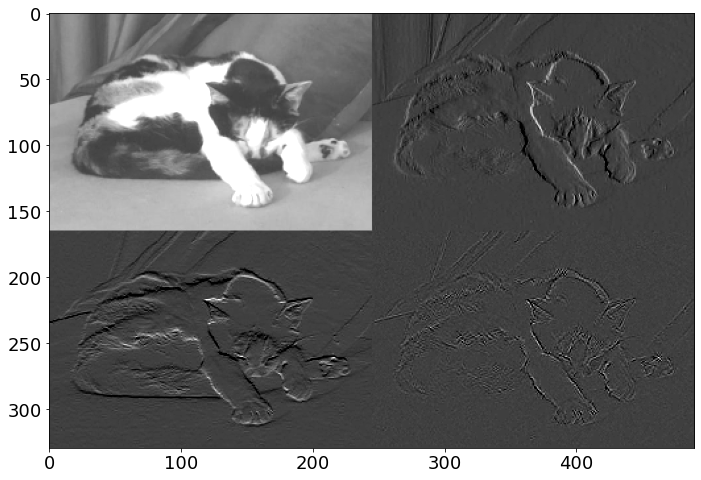

In [10]:
## Wavelet decomposition (2 level)
n = 1
w = 'db1'
coeffs = pywt.wavedec2(B,wavelet=w,level=n)

# normalize each coefficient array
coeffs[0] /= np.abs(coeffs[0]).max()
for detail_level in range(n):
    coeffs[detail_level + 1] = [d/np.abs(d).max() for d in coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(coeffs)

plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)
plt.show()

Para explicar exatamente o que está acontecendo na imagem acima eu vou necessitar da ajuda de uma das maiores pesquisadoras da área hoje, Ingrid Daubechies, com base nos slides desta [aula](https://www.youtube.com/watch?v=tMV61BZCrhk). 


### Compressão de imagens:

&emsp; Uma das principais aplicações, tanto da tansformada de Fourier quanto das Wavelets, é a compressão de sinais e imagens, destancando-se a segunda. A relevância da compressão de imagens se dá em diversos contextos, quase todas imagens disponíveis para nosso acesso são comprimidas por fatores grandes, para serem acessíveis pela internet, não ocuparem espaços proibitivos nas unidades de armazenamento, entre outros fatos. Por exemplo na compressão antiga JPEG, que utilizava a FFT para compressão, o arquivo armazena uma série de módulos e fases de senos e cossenos que serão inversamente transformados quando houver a necessidade de exibir a imagem da forma convensional que estamos acostumados. Neste processo o *Fast* da FFT se torna muito importante, para não tornar proibitivo a conversão e exibição das imagens.

&emsp; Como visto na explicação acima, grande parte das imagens é referente apenas à pequenas variações entre os seus píxels, a parte realmente interessante das imagens, notóriamente as features, não aparecem com tanta frequência na imagem, consequentemente podemos filtrar essa grande parte de informação "pouco relevante", mantendo ainda a grande parte das features na imagem e ao mesmo tempo reduzindo expressivamente seus tamanhos, veja a aplicação em código abaixo:

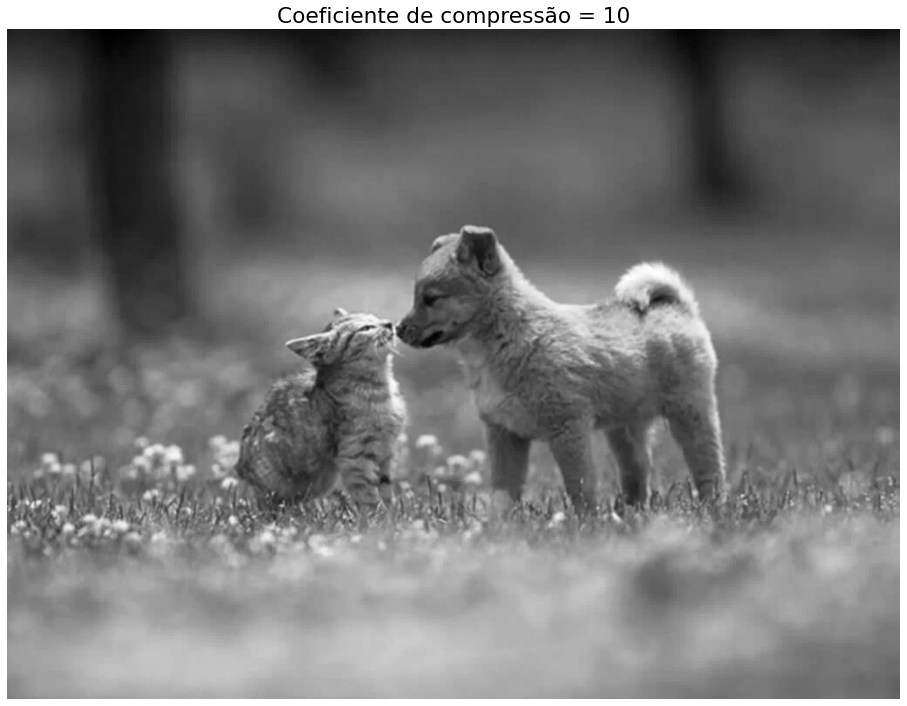

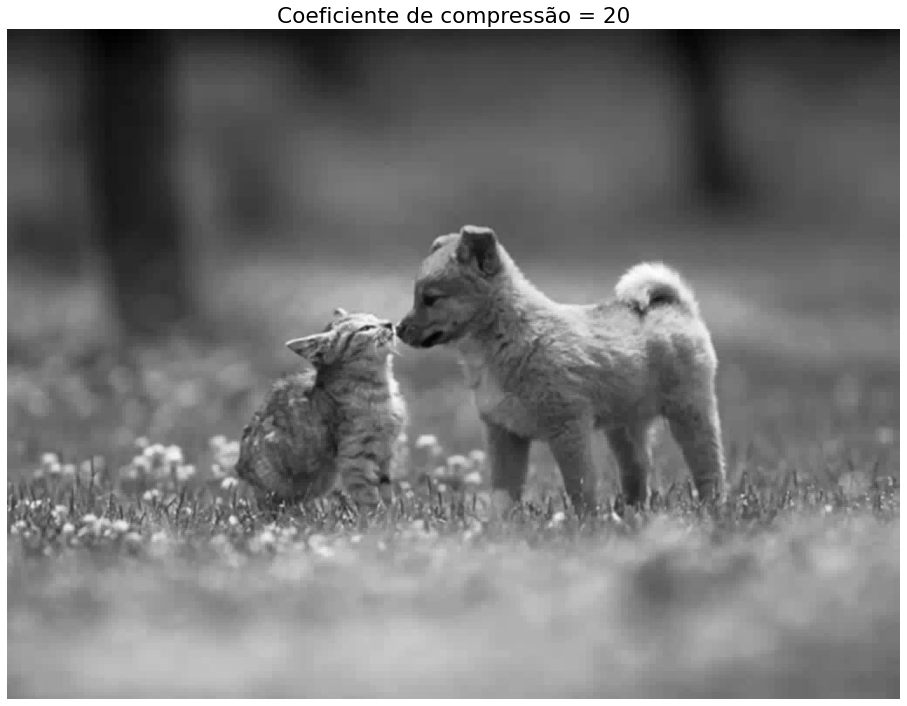

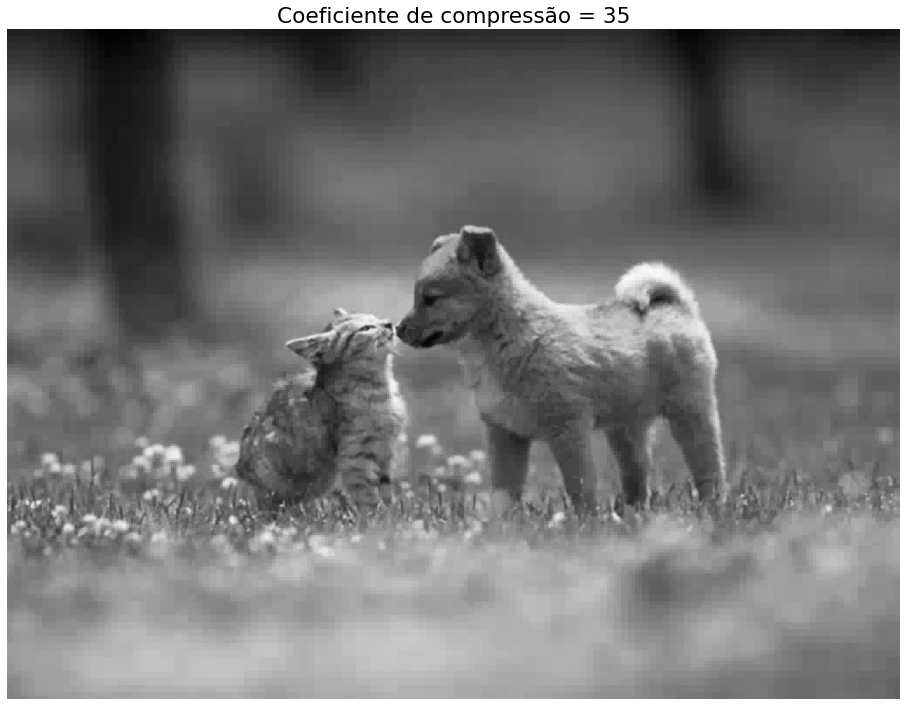

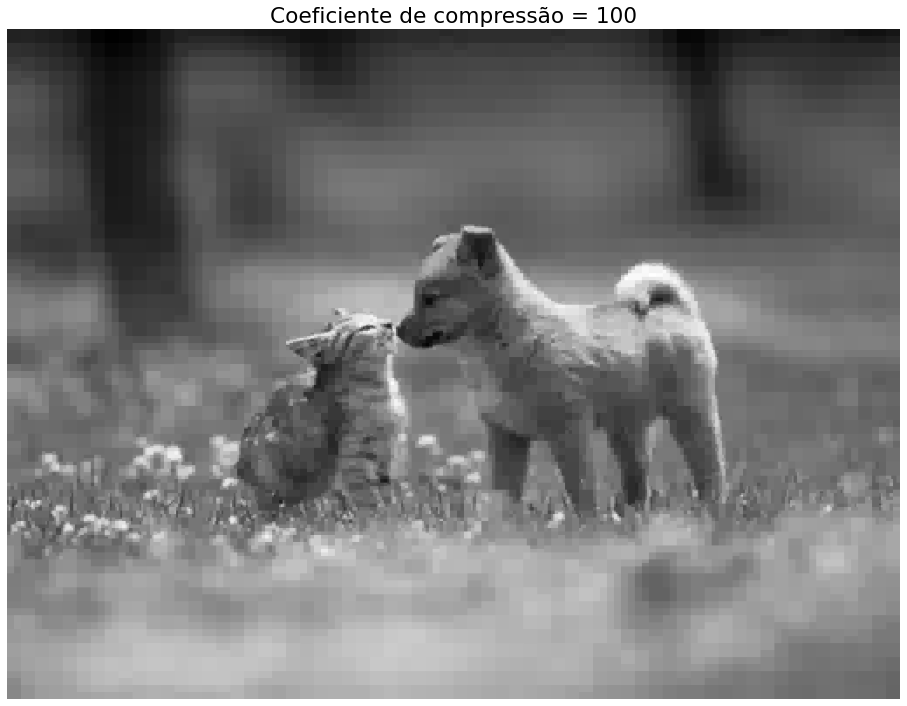

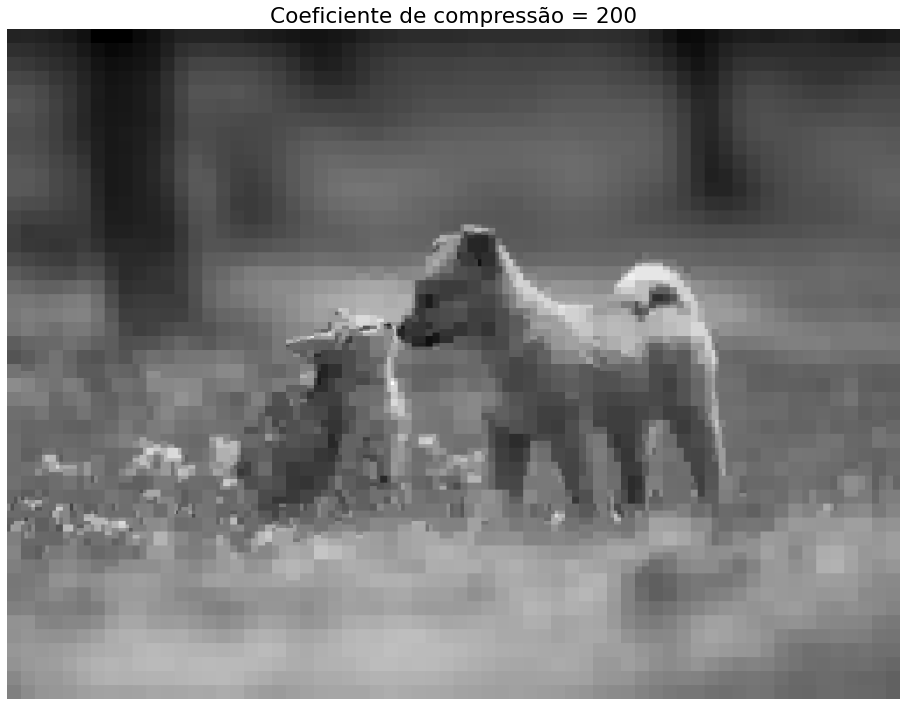

In [11]:
plt.rcParams['figure.figsize'] = [16, 18]
plt.rcParams.update({'font.size': 18})

path_buzz = 'imgs/dogncat.jpeg'

A = imread(path_buzz)                                    # Leitura da imagem 
B = np.mean(A, -1);                                      # Converte de RGB para escala de cinza

n = 4                                                    # Nível de compressão da wavelet
w = 'db1'                                                # Definição da wavelet mãe (neste caso Daubechies 1)
coeffs = pywt.wavedec2(B,wavelet=w,level=n)              # Cálculo dos coeficientes com a transformada wavelet

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)   # Convesão para array, apenas para manipulação matemática
    
Csort = np.sort(np.abs(coeff_arr.reshape(-1)))           # Dar um sort no array de coeficientes com base no módulo (lembre que os coeficientes são números complexos)

for keep in (10, 20, 35, 100, 200):                      # Níveis de compressão desejada
    thresh = Csort[int(np.floor((1-1/keep)*len(Csort)))] # Definição do nível de threshold a ser aplicado
    ind = np.abs(coeff_arr) > thresh                     # Criação de uma máscara de acordo com os níveis a serem mantidos
    Cfilt = coeff_arr * ind                              # Aplicação da máscara
    
    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2')
    
    # Plots
    Arecon = pywt.waverec2(coeffs_filt, wavelet=w)
    plt.figure()
    plt.imshow(Arecon.astype('uint8'),cmap='gray')
    plt.axis('off')
    plt.title('Coeficiente de compressão = ' + str(keep))

&emsp; Algo importante de ser notado neste tipo de compressão é que elementos de alta frequência, texturas, grama, pelo, qualquer feature que oscile muito, são mais difíceis de serem comprimidas  consequentemente apresentam maior dificuldade de aplicação dos métodos de compressão. Outro fator de alta importância para a eficiência da compressão de arquivos é a resolução inicial da imagem, quanto menor a imagem mais complicado é de ser comprimida. Para entender a questão das features de alta frequência, veja o código abaixo, note que ambas imagens utilizadas tem o mesmo tamanho, justamente para que isto não seja um fator de influência no resultado:

In [12]:
path_sulli = 'imgs/sulli.jpeg'
path_buzz = 'imgs/buzz.jpeg'

coeffs_filt_sulli = []
coeffs_filt_buzz = []

sulli = imread(path_sulli)
buzz = imread(path_buzz)

sullig = np.mean(sulli, -1); # Convert RGB to grayscale
buzzg = np.mean(buzz, -1); # Convert RGB to grayscale

n = 4
w = 'db1'

coeffs_sulli = pywt.wavedec2(sullig, wavelet=w, level=n)
coeffs_buzz = pywt.wavedec2(buzzg, wavelet=w, level=n)

coeff_arr_sulli, coeff_slices_sulli = pywt.coeffs_to_array(coeffs_sulli)
coeff_arr_buzz, coeff_slices_buzz = pywt.coeffs_to_array(coeffs_buzz)
    
Csort_sulli = np.sort(np.abs(coeff_arr_sulli.reshape(-1)))
Csort_buzz = np.sort(np.abs(coeff_arr_buzz.reshape(-1)))


for keep in ([0.025]):
    thresh_sulli = Csort_sulli[int(np.floor((1-keep)*len(Csort_sulli)))]
    thresh_buzz = Csort_buzz[int(np.floor((1-keep)*len(Csort_buzz)))]
    
    ind_sulli = np.abs(coeff_arr_sulli) > thresh_sulli
    ind_buzz = np.abs(coeff_arr_buzz) > thresh_buzz

    Cfilt_sulli = coeff_arr_sulli * ind_sulli # Threshold small indices
    Cfilt_buzz = coeff_arr_buzz * ind_buzz # Threshold small indices
    
    coeffs_filt_sulli.append(pywt.array_to_coeffs(Cfilt_sulli, coeff_slices_sulli, output_format='wavedec2'))
    coeffs_filt_buzz.append(pywt.array_to_coeffs(Cfilt_buzz, coeff_slices_buzz, output_format='wavedec2'))

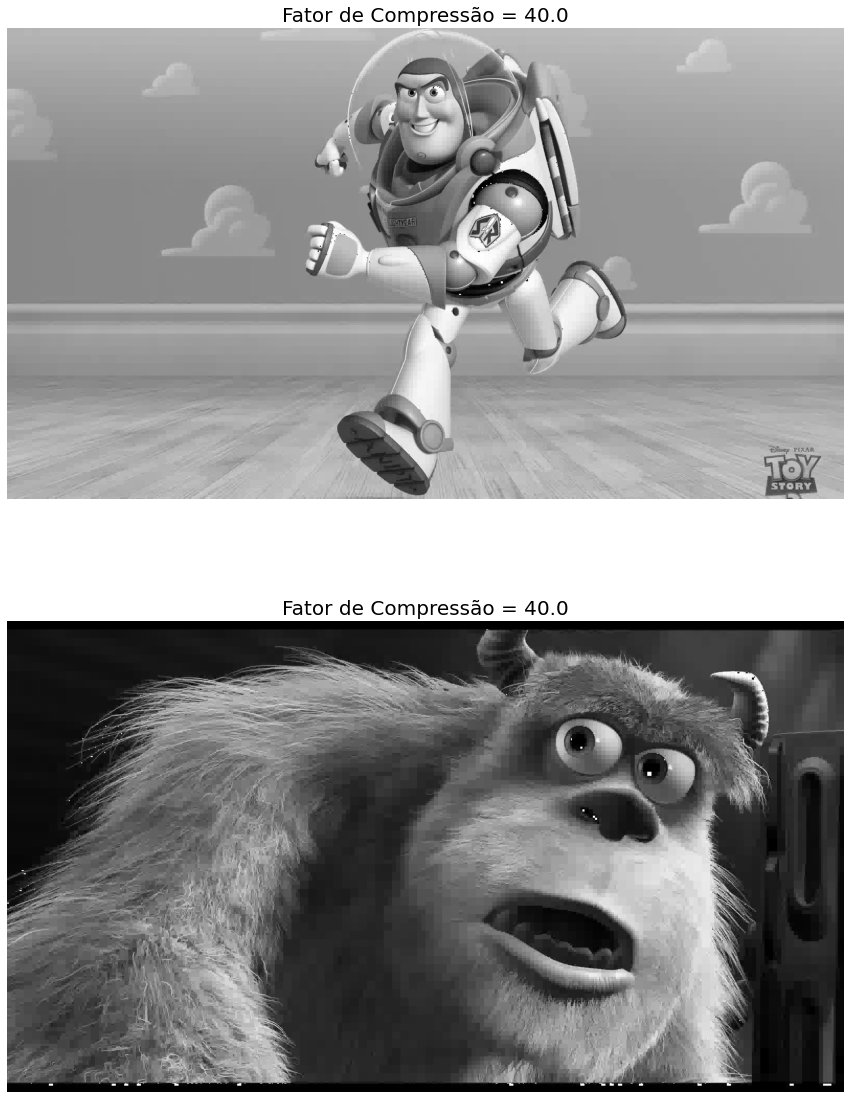

In [13]:
%matplotlib inline
for i in range(0, len(coeffs_filt_sulli)*2, 2):
    coeffs_filt[i+1] = coeffs_filt_sulli[i//2]
    coeffs_filt[i] = coeffs_filt_buzz[i//2]
    
fig, axs = plt.subplots(2, 1, figsize=(15,20))
# Plot image
for i, ax in enumerate(axs.ravel()):
    rest = pywt.waverec2(coeffs_filt[i], wavelet=w)
    img = ax.imshow(rest.astype('uint8'), cmap='gray')
    img.set_cmap('gray')
    ax.axis('off')
    ax.set_title('Fator de Compressão = ' + str(1/keep), fontsize = 20)
plt.show()

In [14]:
path_sulli = 'imgs/sulli.jpeg'

coeffs_filt_wave = []
coeffs_filt_fft  = []

sulli = imread(path_sulli)

sullig = np.mean(sulli, -1); # Convert RGB to grayscale

n = 2
w = 'db1'

coeffs_wave = pywt.wavedec2(sullig, wavelet=w, level=n)
coeffs_fft = np.fft.fft2(sullig)

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs_wave)
    
Csort_wave = np.sort(np.abs(coeff_arr.reshape(-1)))
Csort_fft = np.sort(np.abs(coeffs_fft.reshape(-1)))


for keep in ([1]):
    thresh_wave = Csort_wave[int(np.floor((1-1/keep)*len(Csort_wave)))]
    thresh_fft = Csort_fft[int(np.floor((1-1/keep)*len(Csort_fft)))]
    
    ind_wave = np.abs(coeff_arr) > thresh_wave
    ind_fft = np.abs(coeffs_fft) > thresh_fft

    Cfilt_wave = coeff_arr * ind_wave # Threshold small indices
    Cfilt_fft = coeffs_fft * ind_fft # Threshold small indices
    
    coeffs_filt_wave.append(pywt.array_to_coeffs(Cfilt_sulli, coeff_slices_sulli, output_format='wavedec2'))
    coeffs_filt_fft.append(Cfilt_fft)

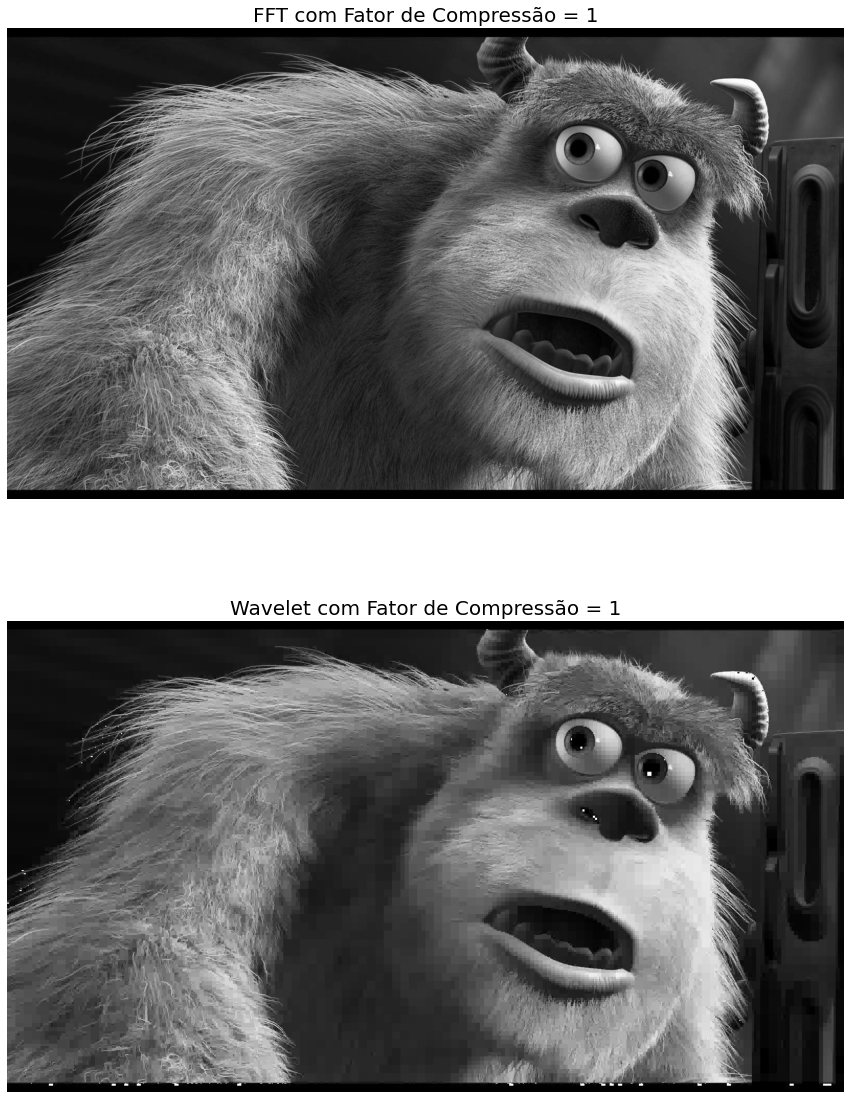

In [15]:
%matplotlib inline

fig, axs = plt.subplots(2, 1, figsize=(15,20))
# Plot image
rest_fft = np.fft.ifft2(coeffs_filt_fft[0]).real
img = axs[0].imshow(rest_fft.astype('uint8'), cmap='gray')
img.set_cmap('gray')
axs[0].axis('off')
axs[0].set_title('FFT com Fator de Compressão = ' + str(keep), fontsize = 20)

rest_wave = pywt.waverec2(coeffs_filt_wave[0], wavelet=w)
img = axs[1].imshow(rest_wave.astype('uint8'), cmap='gray')
img.set_cmap('gray')
axs[1].axis('off')
axs[1].set_title('Wavelet com Fator de Compressão = ' + str(keep), fontsize = 20)
plt.show()

## Como vamos aplicar Wavelets?

Estamos aprendendo essa transformada porque ela foi citada no paper que estamos utilizando como referência para o projeto. Dedicaremos essa seção para lembrar um pouco do artigo e entender como aplicaremos Wavelets no projeto.

O nosso  projeto segue o seguinte plano:

![Diagrama do Paper](imgs/paper_diagram_1.PNG)

Em seguida ele detalha o procedimento utilizado no bloco amarelo:

![Parágrafo](imgs/text.PNG)

O objetivo é gerar o seguinte indice:
$$WaWI = \frac{(log(A_{b5})- log(A_{b3}))}{(log(A_{b5}) + log(A_{b3}))}$$

Tal índice é bem parecido com o que já pesquisamos, como NDVI e NDWI mas os autores clamam que este é mais eficaz em extração de corpos dágua.



[![](http://img.youtube.com/vi/XJ6XXjAOvmY/0.jpg)](http://www.youtube.com/watch?v=XJ6XXjAOvmY "")